<a href="https://colab.research.google.com/github/conwayjw97/ImageColourizationModels/blob/master/src/DeterministicConvNetCifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Global Variables

In [0]:
IMAGE_COUNT = 50000

# These are starting indices, there will be 8 images shown in total
TRAINING_IMAGE = 0
TEST_IMAGE = 0

BATCH_SIZE = 1000
EPOCHS = 500

# Import Statements

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

#%load_ext tensorboard

import tensorflow as tf
import datetime, os
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage.filters import gaussian_filter1d
from tensorflow.keras import datasets, layers, models, backend

TensorFlow 2.x selected.


# Load Images

In [0]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images = train_images / 255.0
test_images = test_images / 255.0

def imageLoader(images, batch_size):
    # Keras needs the generator to loop infinitely
    while True:
        batch_start = 0
        batch_end = batch_size
        while batch_start < len(images):
            limit = min(batch_end, len(images))
            X = tf.expand_dims(images[batch_start:limit,:,:,0], 3)
            Y = images[batch_start:limit,:,:,1:]
            yield (X,Y)   
            batch_start += batch_size   
            batch_end += batch_size

# Convert to YUV

In [0]:
# Outputs a tensor of the same shape as the images tensor, containing the YUV 
# value of the pixels. The output is only well defined if the value in images 
# are in [0,1].
#https://zhengtq.github.io/2018/12/27/tensorflow-disturb-yuv/

train_yuvImages = tf.image.rgb_to_yuv(train_images[:IMAGE_COUNT])
train_y = tf.expand_dims(train_yuvImages[:,:,:,0], 3)
train_uv = train_yuvImages[:,:,:,1:]

test_yuvImages = tf.image.rgb_to_yuv(test_images[:IMAGE_COUNT])
test_y = tf.expand_dims(test_yuvImages[:,:,:,0], 3)
test_uv = test_yuvImages[:,:,:,1:]

In [0]:
# fig = plt.figure(figsize=(25, 16))
# for i in range(8):
#   fig.add_subplot(1,8,i+1)
#   plt.title("Training RGB image")
#   plt.imshow(train_images[TRAINING_IMAGE+i])

# fig = plt.figure(figsize=(25, 16))
# for i in range(8):
#   fig.add_subplot(1,8,i+1)
#   plt.title("Training Greyscale image")
#   plt.imshow((tf.image.grayscale_to_rgb(train_y[TRAINING_IMAGE+i])))

# fig = plt.figure(figsize=(25, 16))
# for i in range(8):
#   fig.add_subplot(1,8,i+1)
#   plt.title("Training Y image")
#   plt.imshow(train_yuvImages[TRAINING_IMAGE+i,:,:,0])
  
# fig = plt.figure(figsize=(25, 16))
# for i in range(8):
#   fig.add_subplot(1,8,i+1)
#   plt.title("Training U image")
#   plt.imshow(train_yuvImages[TRAINING_IMAGE+i,:,:,1])
  
# fig = plt.figure(figsize=(25, 16))
# for i in range(8):
#   fig.add_subplot(1,8,i+1)
#   plt.title("Training V image")
#   plt.imshow(train_yuvImages[TRAINING_IMAGE+i,:,:,2])

In [0]:
# fig = plt.figure(figsize=(25, 16))
# for i in range(8):
#   fig.add_subplot(1,8,i+1)
#   plt.title("Testing RGB image")
#   plt.imshow(test_images[TRAINING_IMAGE+i])

# fig = plt.figure(figsize=(25, 16))
# for i in range(8):
#   fig.add_subplot(1,8,i+1)
#   plt.title("Testing Greyscale image")
#   plt.imshow((tf.image.grayscale_to_rgb(test_y[TEST_IMAGE+i])))

# fig = plt.figure(figsize=(25, 16))
# for i in range(8):
#   fig.add_subplot(1,8,i+1)
#   plt.title("Testing Y image")
#   plt.imshow(test_yuvImages[TEST_IMAGE+i,:,:,0])
  
# fig = plt.figure(figsize=(25, 16))
# for i in range(8):
#   fig.add_subplot(1,8,i+1)
#   plt.title("Testing U image")
#   plt.imshow(test_yuvImages[TEST_IMAGE+i,:,:,1])
  
# fig = plt.figure(figsize=(25, 16))
# for i in range(8):
#   fig.add_subplot(1,8,i+1)
#   plt.title("Testing V image")
#   plt.imshow(test_yuvImages[TEST_IMAGE+i,:,:,2])

# Create the Convolutional Neural Network

In [0]:
# Conv2D(filters (number of output filters)
#           - determine parameter number
#        kernel_size (size of convolution window)
#        activation (activation function to use)
#        padding ("valid" or "same")
#        strides (strides of the convolution along the height and width)
#           - strides greater than 1 will downsample
#        input_shape (only used on the first layer of the model))
#
# UpSampling2D(size (upsampling factors for rows and columns))

#https://github.com/emilwallner/Coloring-greyscale-images

# For an odd-sized filter, all the previous layer pixels would be symmetrically 
# around the output pixel. If you think of convolution as an interpolation from 
# the given pixels to a center pixel, we cannot interpolate to a center pixel 
# using an even-sized filter.

def create_model_very_shallow():
  model = models.Sequential()
  model.add(layers.Conv2D(8, (2, 2), activation='relu', input_shape=(train_uv.shape[1], train_uv.shape[2], 1)))
  model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(2, (3, 3), activation='tanh', padding='same'))
  return model

def create_model_mid1_shallow():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (2, 2), activation='relu', input_shape=(train_uv.shape[1], train_uv.shape[2], 1)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(2, (3, 3), activation='tanh', padding='same'))
  return model

# def create_model_mid2_shallow():
#   model = models.Sequential()
#   model.add(layers.Conv2D(32, (2, 2), activation='relu', input_shape=(train_uv.shape[1], train_uv.shape[2], 1)))
#   model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
#   model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
#   model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
#   model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
#   model.add(layers.UpSampling2D((2, 2)))
#   model.add(layers.Conv2D(2, (3, 3), activation='tanh', padding='same'))
#   return model

def create_model_mid2_shallow():
  model = models.Sequential()
  model.add(layers.Conv2D(8, (2, 2), activation='relu', input_shape=(train_uv.shape[1], train_uv.shape[2], 1)))
  model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(2, (3, 3), activation='tanh', padding='same'))
  return model

def create_model_mid3_shallow():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (2, 2), activation='relu', input_shape=(train_uv.shape[1], train_uv.shape[2], 1)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(2, (3, 3), activation='tanh', padding='same'))
  return model

def create_model_shallow():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(train_uv.shape[1], train_uv.shape[2], 1)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(2, (3, 3), activation='tanh', padding='same'))
  return model

def create_model_mid():
  model = models.Sequential()
  model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(train_uv.shape[1], train_uv.shape[2], 1)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(2, (3, 3), activation='tanh', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  return model

def create_model_deep():
  model = models.Sequential()
  model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(train_uv.shape[1], train_uv.shape[2], 1)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(2, (3, 3), activation='tanh', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  return model

# create_model_very_shallow().summary()
# create_model_mid1_shallow().summary()
# create_model_mid2_shallow().summary()
# create_model_mid3_shallow().summary()
# create_model_shallow().summary()
# create_model_mid().summary()
# create_model_deep().summary()

In [0]:
def create_model_very_shallow():
  model = models.Sequential()
  model.add(layers.Conv2D(8, (2, 2), activation='relu', input_shape=(train_uv.shape[1], train_uv.shape[2], 1)))
  model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(2, (3, 3), activation='tanh', padding='same'))
  return model

def create_model_mid1_shallow():
  model = models.Sequential()
  model.add(layers.Conv2D(8, (2, 2), activation='relu', input_shape=(train_uv.shape[1], train_uv.shape[2], 1)))
  model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(2, (3, 3), activation='tanh', padding='same'))
  return model

def create_model_mid15_shallow():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (2, 2), activation='relu', input_shape=(train_uv.shape[1], train_uv.shape[2], 1)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(2, (3, 3), activation='tanh', padding='same'))
  return model

def create_model_mid2_shallow():
  model = models.Sequential()
  model.add(layers.Conv2D(8, (2, 2), activation='relu', input_shape=(train_uv.shape[1], train_uv.shape[2], 1)))
  model.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(2, (3, 3), activation='tanh', padding='same'))
  return model

def create_model_mid25_shallow():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (2, 2), activation='relu', input_shape=(train_uv.shape[1], train_uv.shape[2], 1)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(2, (3, 3), activation='tanh', padding='same'))
  return model

def create_model_mid3_shallow():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (2, 2), activation='relu', input_shape=(train_uv.shape[1], train_uv.shape[2], 1)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(2, (3, 3), activation='tanh', padding='same'))
  return model

create_model_mid1_shallow().summary()
create_model_mid15_shallow().summary()
create_model_mid2_shallow().summary()
create_model_mid25_shallow().summary()
create_model_mid3_shallow().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 31, 8)         40        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 16)        1168      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 32)          4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 16)          4624      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 16)        2320      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 32, 32, 16)        0


# Compile and Train the Model

In [0]:
# fit(x (input data)
#     y (target data)
#     batch_size (samples per gradient update)
#        - smaller batch size = more stochastic
#     epochs (epochs to train the model))

#https://stackoverflow.com/questions/47200146/keras-load-images-batch-wise-for-large-dataset

model = create_model_mid1_shallow()
model.compile(optimizer='rmsprop',
              loss='mse')

runtime_epochs = int(EPOCHS/4)
total_loss = []
total_val_loss = []

history = model.fit_generator(imageLoader(train_yuvImages, BATCH_SIZE), steps_per_epoch=int(train_yuvImages.shape[0]/BATCH_SIZE), epochs=runtime_epochs, validation_data=(imageLoader(test_yuvImages, BATCH_SIZE)), validation_steps=int(test_yuvImages.shape[0]/BATCH_SIZE))
total_loss += history.history["loss"]
total_val_loss += history.history["val_loss"]

Epoch 1/125
50/50 [==============================] - 3s 53ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 2/125
50/50 [==============================] - 2s 32ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 3/125
50/50 [==============================] - 2s 31ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 4/125
50/50 [==============================] - 2s 31ms/step - loss: 0.0035 - val_loss: 0.0036
Epoch 5/125
50/50 [==============================] - 2s 32ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 6/125
50/50 [==============================] - 2s 32ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 7/125
50/50 [==============================] - 2s 31ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 8/125
50/50 [==============================] - 2s 31ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 9/125
50/50 [==============================] - 2s 31ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 10/125
50/50 [==============================] - 2s 31ms/step - loss: 0.0034 - val_loss: 0.0033

In [0]:
#history = model.fit(x=train_y, y=train_uv, validation_data=(test_y, test_uv), batch_size=BATCH_SIZE, epochs=runtime_epochs)
history = model.fit_generator(imageLoader(train_yuvImages, BATCH_SIZE), steps_per_epoch=int(train_yuvImages.shape[0]/BATCH_SIZE), epochs=runtime_epochs, validation_data=(imageLoader(test_yuvImages, BATCH_SIZE)), validation_steps=int(test_yuvImages.shape[0]/BATCH_SIZE))
total_loss += history.history["loss"]
total_val_loss += history.history["val_loss"]

Epoch 1/125
50/50 [==============================] - 2s 31ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 2/125
50/50 [==============================] - 2s 30ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 3/125
50/50 [==============================] - 2s 31ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 4/125
50/50 [==============================] - 2s 31ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 5/125
50/50 [==============================] - 2s 31ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 6/125
50/50 [==============================] - 2s 31ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 7/125
50/50 [==============================] - 2s 31ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 8/125
50/50 [==============================] - 2s 31ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 9/125
50/50 [==============================] - 2s 31ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 10/125
50/50 [==============================] - 2s 31ms/step - loss: 0.0031 - val_loss: 0.0031

In [0]:
#history = model.fit(x=train_y, y=train_uv, validation_data=(test_y, test_uv), batch_size=BATCH_SIZE, epochs=runtime_epochs)
history = model.fit_generator(imageLoader(train_yuvImages, BATCH_SIZE), steps_per_epoch=int(train_yuvImages.shape[0]/BATCH_SIZE), epochs=runtime_epochs, validation_data=(imageLoader(test_yuvImages, BATCH_SIZE)), validation_steps=int(test_yuvImages.shape[0]/BATCH_SIZE))
total_loss += history.history["loss"]
total_val_loss += history.history["val_loss"]

Epoch 1/125
50/50 [==============================] - 2s 31ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 2/125
50/50 [==============================] - 2s 31ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 3/125
50/50 [==============================] - 2s 31ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 4/125
50/50 [==============================] - 2s 31ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 5/125
50/50 [==============================] - 2s 31ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 6/125
50/50 [==============================] - 2s 31ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 7/125
50/50 [==============================] - 2s 31ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 8/125
50/50 [==============================] - 2s 31ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 9/125
50/50 [==============================] - 2s 31ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 10/125
50/50 [==============================] - 2s 31ms/step - loss: 0.0030 - val_loss: 0.0031

In [0]:
#history = model.fit(x=train_y, y=train_uv, validation_data=(test_y, test_uv), batch_size=BATCH_SIZE, epochs=runtime_epochs)
history = model.fit_generator(imageLoader(train_yuvImages, BATCH_SIZE), steps_per_epoch=int(train_yuvImages.shape[0]/BATCH_SIZE), epochs=runtime_epochs, validation_data=(imageLoader(test_yuvImages, BATCH_SIZE)), validation_steps=int(test_yuvImages.shape[0]/BATCH_SIZE))
total_loss += history.history["loss"]
total_val_loss += history.history["val_loss"]

Epoch 1/125
50/50 [==============================] - 2s 31ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 2/125
50/50 [==============================] - 2s 31ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 3/125
50/50 [==============================] - 2s 31ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 4/125
50/50 [==============================] - 2s 30ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 5/125
50/50 [==============================] - 2s 30ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 6/125
50/50 [==============================] - 2s 30ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 7/125
50/50 [==============================] - 2s 31ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 8/125
50/50 [==============================] - 2s 31ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 9/125
50/50 [==============================] - 2s 31ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 10/125
50/50 [==============================] - 2s 31ms/step - loss: 0.0030 - val_loss: 0.0031

# Loss Function Results

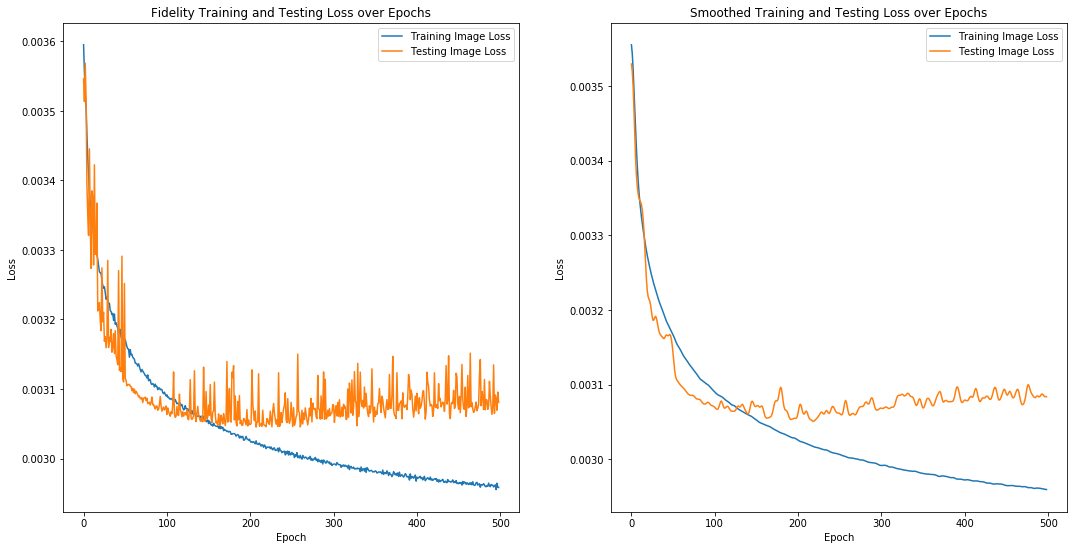

In [0]:
fig = plt.figure(figsize=(18, 9))
fig.add_subplot(1,2,1)
plt.title("Fidelity Training and Testing Loss over Epochs")
plt.plot(total_loss[1:], label="Training Image Loss")
plt.plot(total_val_loss[1:], label="Testing Image Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
fig.add_subplot(1,2,2)
plt.title("Smoothed Training and Testing Loss over Epochs")
plt.plot(gaussian_filter1d(total_loss[1:], sigma=2), label="Training Image Loss")
plt.plot(gaussian_filter1d(total_val_loss[1:], sigma=2), label="Testing Image Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Training Results

50000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


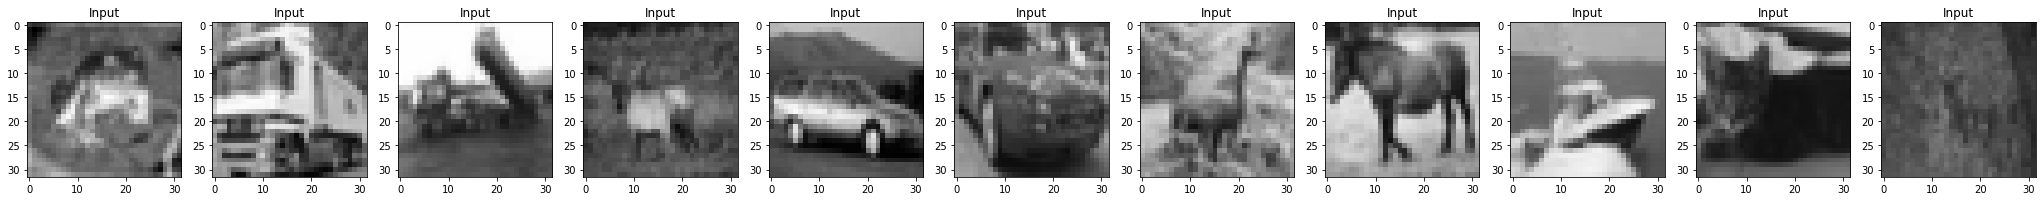

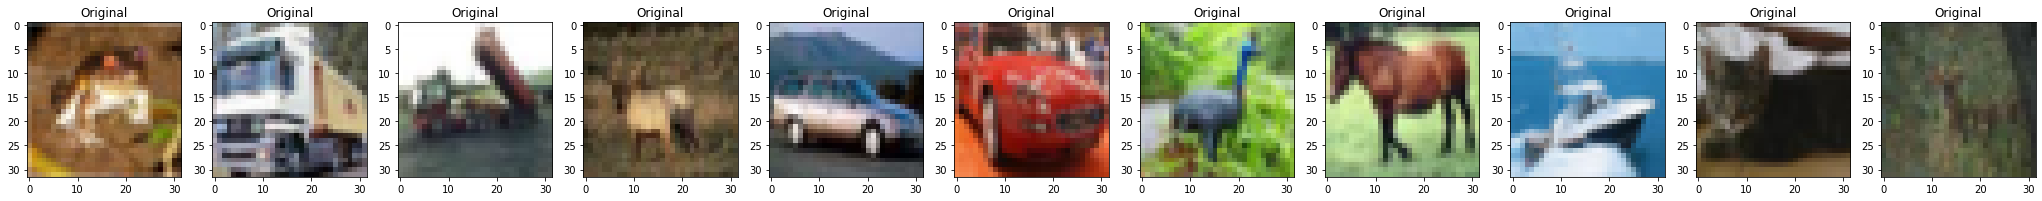

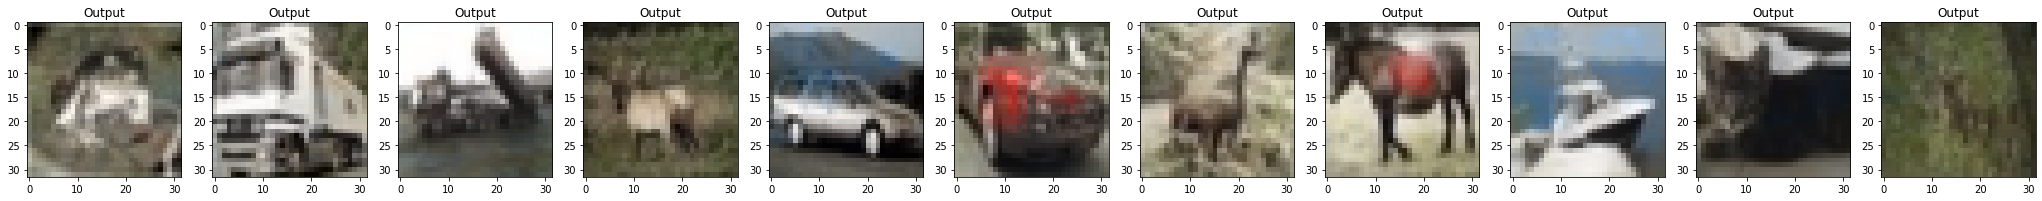

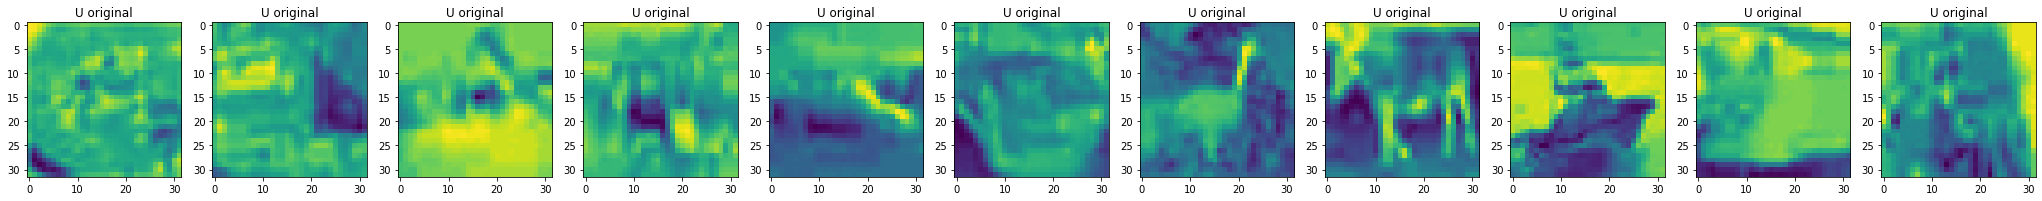

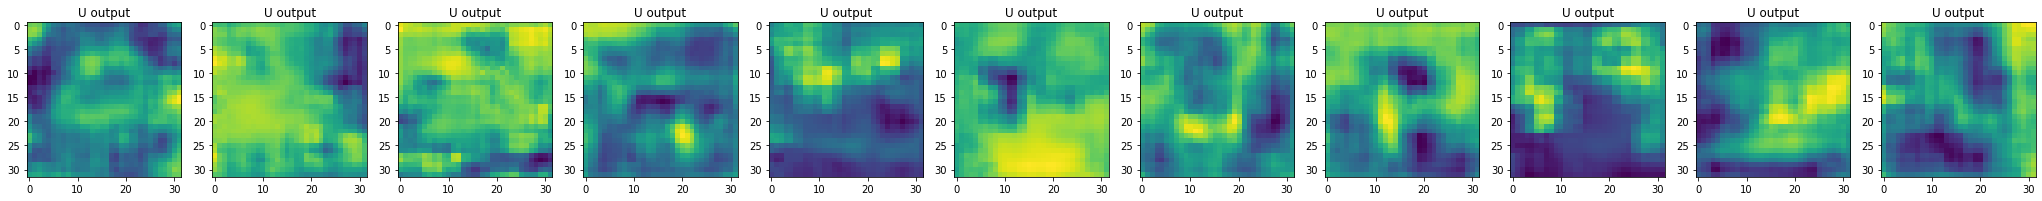

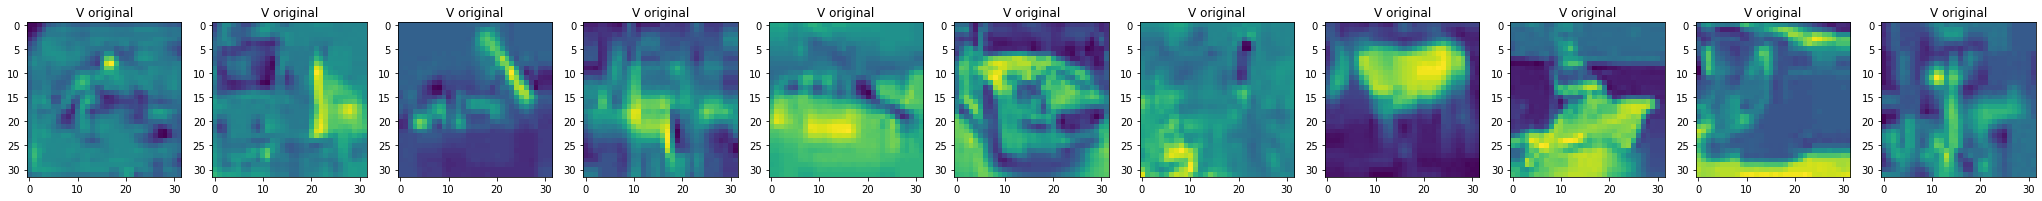

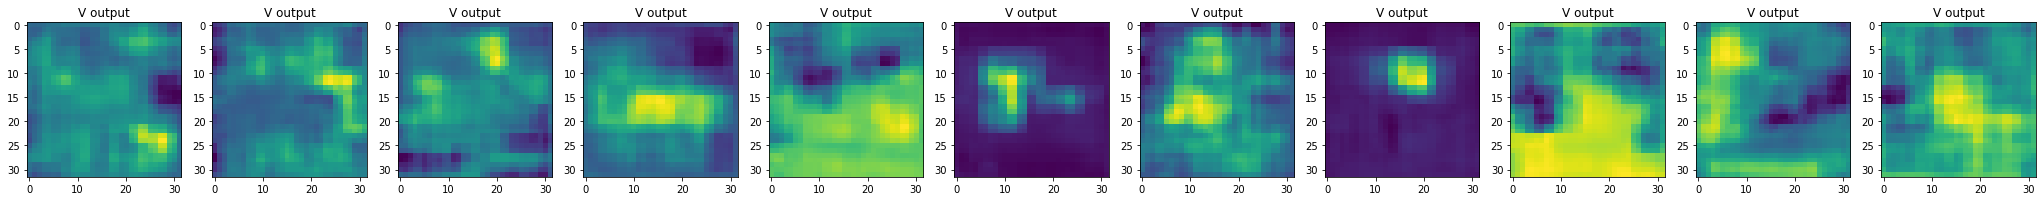

In [0]:
print(model.evaluate(train_y, train_uv, batch_size=BATCH_SIZE))
output = model.predict(train_y)
result = np.zeros((IMAGE_COUNT, 32, 32, 3))
result[:,:,:,0] = train_y[:,:,:,0]
result[:,:,:,1:] = output

output_count = 11

fig = plt.figure(figsize=(36, 16))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Input")
  plt.imshow(tf.image.grayscale_to_rgb(train_y[TRAINING_IMAGE+i]))

fig = plt.figure(figsize=(36, 16))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Original")
  plt.imshow(train_images[TRAINING_IMAGE+i])

fig = plt.figure(figsize=(36, 16))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Output")
  plt.imshow(tf.image.yuv_to_rgb(result[TRAINING_IMAGE+i]))
  
fig = plt.figure(figsize=(36, 16))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U original")
  plt.imshow(train_yuvImages[TRAINING_IMAGE+i,:,:,1])
  
fig = plt.figure(figsize=(36, 16))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U output")
  plt.imshow(result[TRAINING_IMAGE+i,:,:,1])
  
fig = plt.figure(figsize=(36, 16))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V original")
  plt.imshow(train_yuvImages[TRAINING_IMAGE+i,:,:,2])
  
fig = plt.figure(figsize=(36, 16))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V output")
  plt.imshow(result[TRAINING_IMAGE+i,:,:,2])

# Testing Results

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


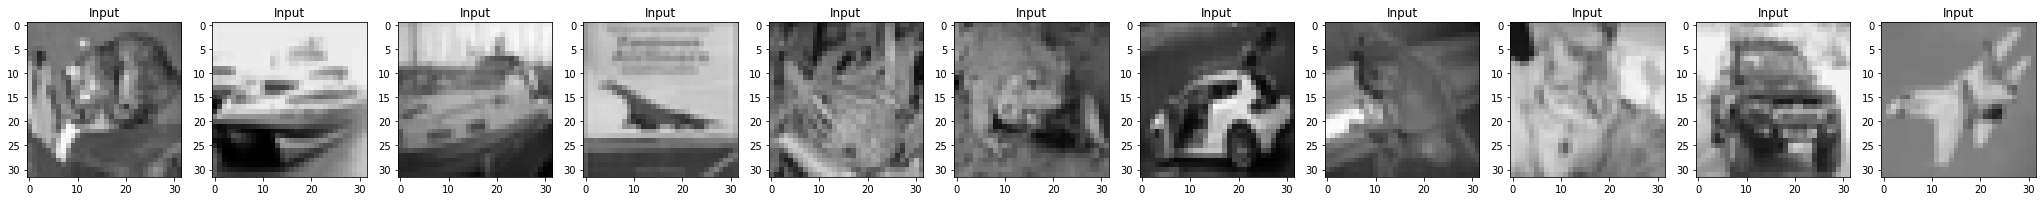

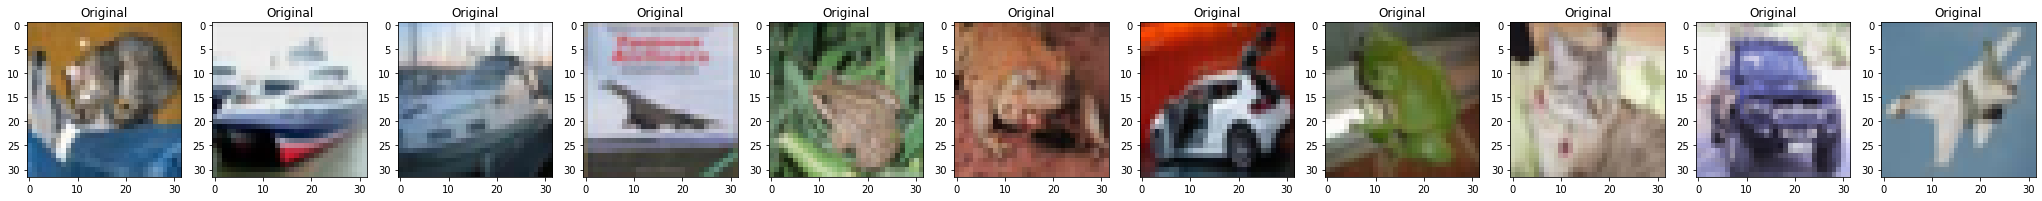

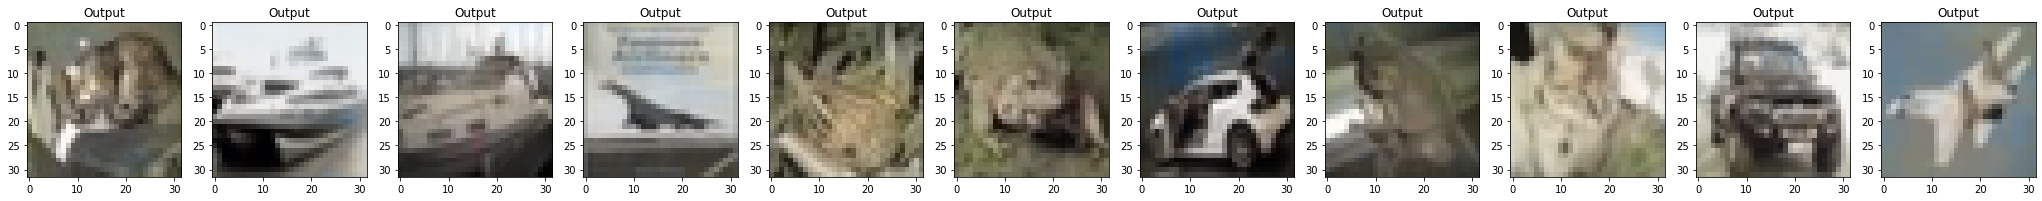

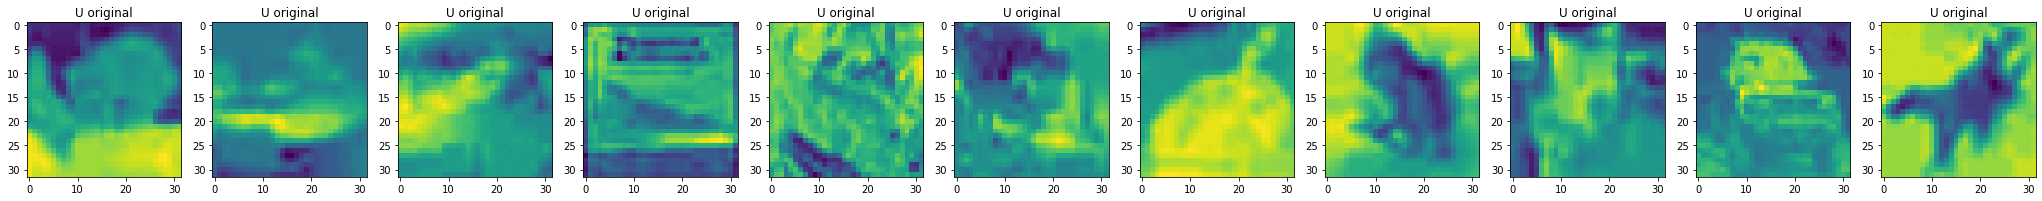

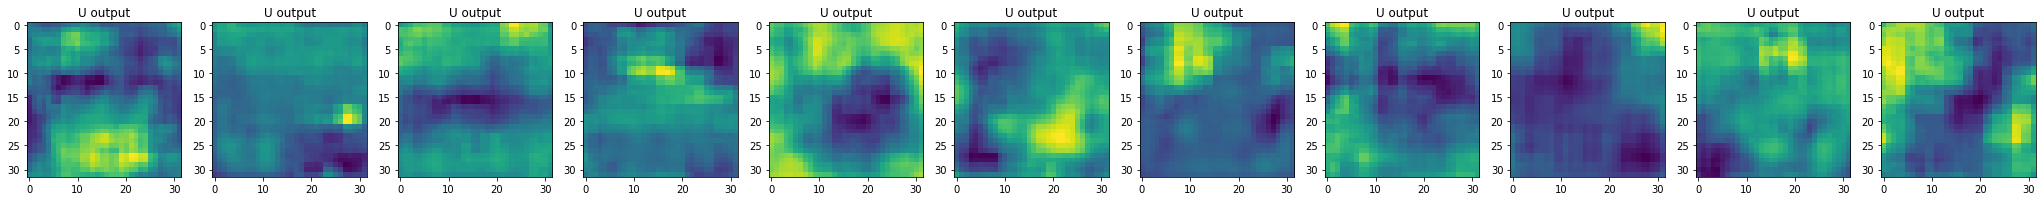

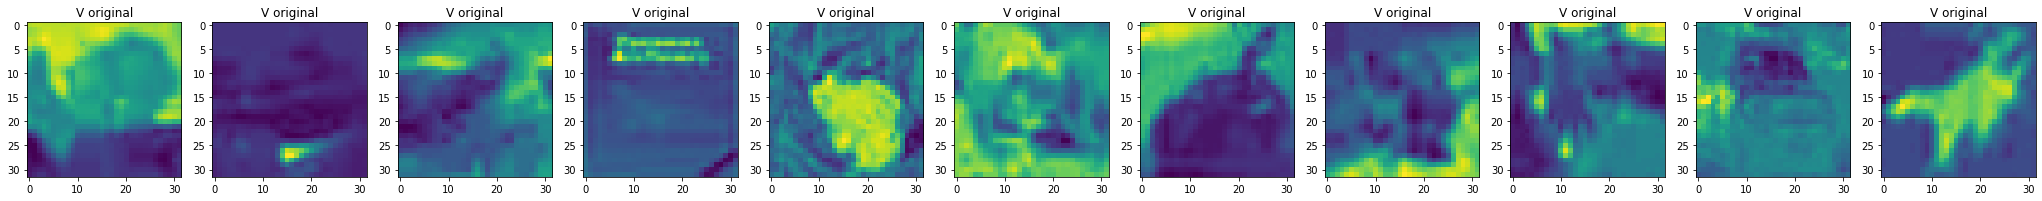

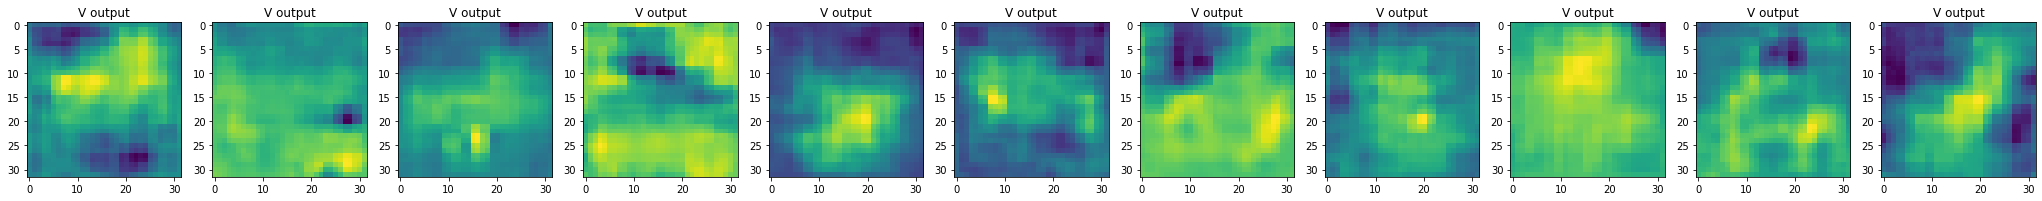

In [0]:
print(model.evaluate(test_y, test_uv, batch_size=BATCH_SIZE))
output = model.predict(test_y)
result = np.zeros((test_yuvImages.shape[0], 32, 32, 3))
result[:,:,:,0] = test_y[:,:,:,0]
result[:,:,:,1:] = output
  
output_count = 11

fig = plt.figure(figsize=(36, 16))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Input")
  plt.imshow(tf.image.grayscale_to_rgb(test_y[TEST_IMAGE+i]))

fig = plt.figure(figsize=(36, 16))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Original")
  plt.imshow(test_images[TEST_IMAGE+i])

fig = plt.figure(figsize=(36, 16))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Output")
  plt.imshow(tf.image.yuv_to_rgb(result[TEST_IMAGE+i]))
  
fig = plt.figure(figsize=(36, 16))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U original")
  plt.imshow(test_yuvImages[TEST_IMAGE+i,:,:,1])
  
fig = plt.figure(figsize=(36, 16))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U output")
  plt.imshow(result[TEST_IMAGE+i,:,:,1])
  
fig = plt.figure(figsize=(36, 16))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V original")
  plt.imshow(test_yuvImages[TEST_IMAGE+i,:,:,2])
  
fig = plt.figure(figsize=(36, 16))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V output")
  plt.imshow(result[TEST_IMAGE+i,:,:,2])

# Layers activation visualization

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


RuntimeError: ignored

<Figure size 648x0 with 1 Axes>

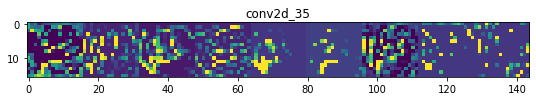

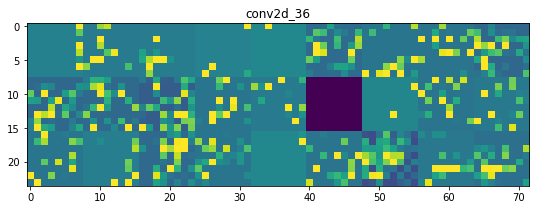

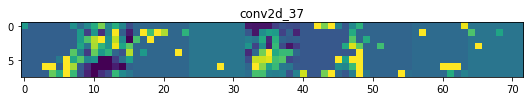

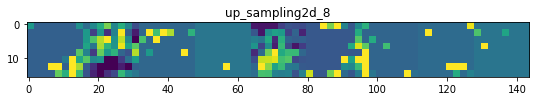

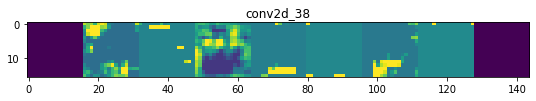

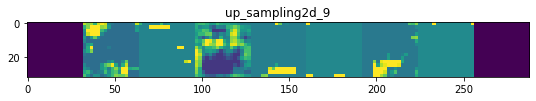

RuntimeError: ignored

<Figure size 648x0 with 1 Axes>

In [0]:
#https://github.com/gabrielpierobon/cnnshapes/blob/master/README.md
layer_outputs = [layer.output for layer in model.layers[:12]] # Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input
activations = activation_model.predict(test_y) # Returns a list of five Numpy arrays: one array per layer activation

layer_names = []
for layer in model.layers[:12]:
  layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot

images_per_row = 9

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
  n_features = layer_activation.shape[-1] # Number of features in the feature map
  size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
  n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
  display_grid = np.zeros((size * n_cols, images_per_row * size))
  for col in range(n_cols): # Tiles each filter into a big horizontal grid
    for row in range(images_per_row):
      channel_image = layer_activation[0,:, :,col * images_per_row + row]
      channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
      channel_image /= channel_image.std()
      channel_image *= 64
      channel_image += 128
      channel_image = np.clip(channel_image, 0, 255).astype('uint8')
      display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
  scale = 1. / size
  plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
  plt.title(layer_name)
  plt.grid(False)
  plt.imshow(display_grid, aspect='auto', cmap='viridis')